# Código para predição e avaliação da performance nos diversos testes

## Extração de caracteristicas

Exigências: 

            - esm2_t30_150M_UR50D, modelo ESM-2 DE 150M de parametros

            - extrair todas as sequências primárias das proteínas envolvidas na STRING

Solicite ao autor os arquivos .fasta, caso não queria baixar os mesmo da STRING

In [1]:
import esm
import torch
import pandas as pd
import numpy as np
import os


def extract_and_save_embeddings_to_csv(df_fasta, batch_size=32, save_every=1000, output_prefix="esm2_embeddings"): 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)
    model, alphabet = esm.pretrained.esm2_t30_150M_UR50D()
    model = model.to(device)
    model.eval()
    batch_converter = alphabet.get_batch_converter()
    all_rows = [] 
    saved_batches = 0

    batch_sequences = []
    batch_headers = []

    for i, row in enumerate(df_fasta.itertuples(index=False)):
        header, sequence = row.header, row.sequence
        batch_headers.append(header)
        batch_sequences.append((header, sequence))

        if len(batch_sequences) == batch_size or i == len(df_fasta) - 1:
            try:
                batch_labels, batch_strs, batch_tokens = batch_converter(batch_sequences)
                batch_tokens = batch_tokens.to(device)

                with torch.no_grad():
                    results = model(batch_tokens, repr_layers=[30], return_contacts=False)
                    token_representations = results["representations"][30]

                    for j, tokens_len in enumerate((batch_tokens != alphabet.padding_idx).sum(1)):
                        seq_embedding = token_representations[j, 1:tokens_len - 1].mean(0).cpu().numpy()
                        all_rows.append([batch_headers[j]] + seq_embedding.tolist())

            except RuntimeError as e:
                print(f"Erro de memória em {batch_headers}: {e}")
                torch.cuda.empty_cache()
                continue

            # Libera GPU
            del batch_tokens, results, token_representations
            torch.cuda.empty_cache()

            batch_sequences = []
            batch_headers = []

            if (i + 1) % save_every == 0 or i == len(df_fasta) - 1:
                save_path = f"{output_prefix}"
                print(f"Salvando {len(all_rows)} embeddings em {save_path}...")

                df_out = pd.DataFrame(all_rows)
                df_out.to_csv(save_path, index=False, header=False)
                saved_batches += 1
                all_rows = []
    print("Extração finalizada.")

def make_fasta(fasta_path):
    headers = []
    seqs = []
    
    with open(fasta_path, 'r') as f:
        current_header = None
        current_seq = []
    
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if current_header is not None:
                    headers.append(current_header)
                    seqs.append(''.join(current_seq))
                current_header = line[1:].split()[0]
                current_seq = []
            else:
                current_seq.append(line)
        if current_header is not None:
            headers.append(current_header)
            seqs.append(''.join(current_seq))
    
    df_fasta = pd.DataFrame({"header": headers, "sequence": seqs})
    print(f"Total de sequências: {len(df_fasta)}")
    print(df_fasta.head())
    return df_fasta

fasta_path = "datasets/comparacao_tuna/string_planta_tuna.fasta" # Caminho do arquivo fasta
output_feats = "datasets/comparacao_tuna/features_planta_tuna.csv" # Caminho para salvar os descritores


df_fasta = make_fasta(fasta_path)
extract_and_save_embeddings_to_csv(df_fasta, batch_size=1, save_every=10000000, output_prefix=output_feats)

Total de sequências: 21540
            header                                           sequence
0  3055.A0A2K3CNQ0  MGGLQEFYTVPDIVKQWAHYFYRHIRERNIPEIQSMYEISFLKLSD...
1  3055.A0A2K3CPH2  MALQEATALLGRFKDAIGKKDLSTADSLLGQLKVKLIQLPALPPTF...
2  3055.A0A2K3CQB1  MSFRELRSFTEVMKALGYPRLISMENFRVPNFELVADCLYWLVHRY...
3  3055.A0A2K3CQD5  MGKGGDSTDDNHAGPSTSGGSDLLQLPRFQPFLDNNFNVAEFTSKV...
4  3055.A0A2K3CQG9  MGDVSYIVDSLGLPPFSYQMSLLSFTEKGPQELLQLLSDVFSTISP...
Dispositivo: cuda
Salvando 21540 embeddings em datasets/comparacao_tuna/features_planta_tuna.csv...
Extração finalizada.


## Aplicando o modelo para predições

In [18]:
import pandas as pd

feats_path = output_feats # Caminho onde estão os descritores 
ints_path = "datasets/comparacao_tuna/alto_alto_planta_10k.csv" # Caminho para as interações que deseja predizer


# Arquivos alternativos comparação Tuna
#ints_path = "datasets/comparacao_tuna/medio_medio_fungi_10k.csv"
#ints_path = "datasets/comparacao_tuna/baixo_baixo_fungi_10k.csv"

# Arquivos alternativos performance Teste do artigo
#ints_path = "datasets/teste/planta_50_124sp_all_980sc_bal.csv"
#ints_path = "datasets/teste/animal_50_124sp_all_980sc_bal.csv"
#ints_path = "datasets/teste/fungi_50_124sp_all_980sc_bal.csv"
#ints_path = "datasets/teste/outros_clados_50_124sp_all_980sc_bal.csv"


df_feats = pd.read_csv(feats_path, header=None)
df_feats = df_feats.rename(columns={0: "protein1"})
df_combined = pd.read_csv(ints_path)
df_combined = df_combined[['protein1','protein2', 'Label']]
df_merged = df_combined.merge(df_feats, on="protein1", how="left")
df_feats = df_feats.rename(columns={'protein1': "protein2"})
df_merged = df_merged.merge(df_feats, on="protein2", how="left")

In [21]:
feature_cols = df_merged.columns[3:]
X = df_merged[feature_cols]
y = df_merged["Label"]

del df_merged

In [23]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)


scaler_path = "modelo/scaler_planta_920sc.pkl"  # Caminho do modelo de normalização
mlp_loaded = "modelo/MLP_model_planta(512, 256, 128, 64)_e25_920sc.pkl" # Caminho para o modelo preditivo

scaler = joblib.load(scaler_path)
mlp_loaded = joblib.load(mlp_loaded) 
X_scaled = scaler.transform(X)


y_proba = mlp_loaded.predict_proba(X_scaled)[:, 1] 
y_pred = mlp_loaded.predict(X_scaled)  # Rotulo pretivo para cada interação 

# Matriz de confusão: [[TN, FP], [FN, TP]]
tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

# Métricas calculadas manualmente
especificidade = tn / (tn + fp)
sensibilidade = tp / (tp + fn)  # igual ao recall
acuracia = (tp + tn) / (tp + tn + fp + fn)
precisao = tp / (tp + fp)
f1 = 2 * (precisao * sensibilidade) / (precisao + sensibilidade)

print("Acurácia:", acuracia)
print("Precisão:", precisao)
print("Sensibilidade (Recall):", sensibilidade)
print("Especificidade:", especificidade)
print("F1:", f1)

Acurácia: 0.9486
Precisão: 0.9392010965341688
Sensibilidade (Recall): 0.9593
Especificidade: 0.9379
F1: 0.9491441575145939


## Alinhamento e BLAST

Exigências: ter o modelo BLAST baixado (ncbi-blast-2.16.0+)

### Construindo o banco de dados para alinhamento

In [ ]:
import subprocess

makeblastdb_path = r"...\ncbi-blast-2.16.0+\bin\makeblastdb.exe" # Caminho até o makeblastdb.exe
input_fasta_db = r"...\fasta\plantas_0_50_920sc_max1000.fasta" # Caminho até o FASTA que será transformado em um banco de dados para alinhamento
cmd = [
    makeblastdb_path,
    "-in", input_fasta_db,
    "-dbtype", "prot"  # Para banco de proteínas
]
try:
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    print("Banco de dados criado com sucesso!")
    print(result.stdout)
except subprocess.CalledProcessError as e:
    print("Erro ao criar o banco de dados:")
    print(e.stderr)

### Alinhando as sequências

In [ ]:
import subprocess
import pandas as pd

blastp_path = r"C:\Users\Bruno\Downloads\ncbi-blast-2.16.0+\bin\blastp.exe" # Caminho até o blastp.exe 
query_fasta = ".fasta" # Sequências que serão alinhadas 
output_file = ".txt" # Caminho onde serão salvos os alinhamentos
db_path = input_fasta_db  # Banco de dados referência do alinhamento

cmd = [
    blastp_path,
    "-query", query_fasta,
    "-db", db_path,
    "-out", output_file,
    "-outfmt",  "6 qseqid sseqid pident ppos nident mismatch gapopen qlen slen length qstart qend sstart send evalue bitscore",
    "-max_target_seqs", "5",
    "-num_threads", "16" 
]

try:
    result = subprocess.run(cmd, capture_output=True, text=True, check=True)
    print("BLAST concluído com sucesso!")
    print(f"Resultados salvos em: {output_file}")
except subprocess.CalledProcessError as e:
    print("Erro ao executar o BLAST:")
    print(e.stderr)


colunas = [
    "qseqid", "sseqid", "pident", "ppos", "nident", "mismatch", "gapopen",
    "qlen", "slen", "length", "qstart", "qend", "sstart", "send", "evalue", "bitscore"
]

df = pd.read_csv(output_file, sep="\t", names=colunas)
df.to_csv(output_file, sep="\t", index=False)
print("Arquivo salvo com cabeçalho.")

### Visualizando o alinhamento

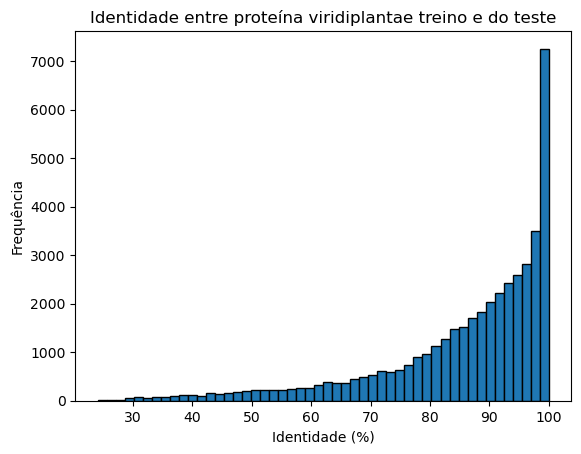

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

colunas = [
    "qseqid", "sseqid", "pident", "ppos", "nident", "mismatch", "gapopen",
    "qlen", "slen", "length", "qstart", "qend", "sstart", "send", "evalue", "bitscore"
]
df = pd.read_csv(
    "datasets/teste/alinhamento_planta920_0-50sp_e_planta_50_124sp.txt", # Indicque o caminho para o alinhamento
    sep="\t",
    header=None,
    names=colunas
)


df_max = df.loc[df.groupby("qseqid")["pident"].idxmax()]
df_top5 = df.sort_values(by=["qseqid", "pident"], ascending=[True, False])  # Ordena por qseqid e pident decrescente
df_top5 = df_top5.groupby("qseqid").head(1)  # Pega os 5 maiores pident por qseqid
df_max = df_top5.groupby("qseqid")["pident"].mean().reset_index()

plt.hist(df_max["pident"], bins=50, edgecolor='black')
plt.xlabel("Identidade (%)")
plt.ylabel("Frequência")
plt.title("Identidade entre proteína viridiplantae treino e do teste")
plt.show()

## Usando o alinhamento para filtrar as predições segundo a identidade

In [31]:
import pandas as pd

def filtrar_interacoes_por_dois_pidents(df_primeiro, df_combined, intervalo_max, intervalo_min):
    try:
        inicio_max, fim_max = map(float, intervalo_max.split("-"))
        inicio_min, fim_min = map(float, intervalo_min.split("-"))
    except:
        raise ValueError("Os intervalos devem estar no formato 'inicio-fim', por exemplo '40-60'.")

    # Conjunto de proteínas válidas
    proteinas_validas = set(df_primeiro["qseqid"])
    
    # Filtra só as interações onde as duas proteínas estão presentes
    df_filtrado = df_combined[
        (df_combined["protein1"].isin(proteinas_validas)) &
        (df_combined["protein2"].isin(proteinas_validas))
    ].copy()

    # Dicionário com pident de cada proteína
    pident_dict = df_primeiro.set_index("qseqid")["pident"].to_dict()

    # Mapeia o pident
    df_filtrado["pident1"] = df_filtrado["protein1"].map(pident_dict)
    df_filtrado["pident2"] = df_filtrado["protein2"].map(pident_dict)

    # Calcula máximo e mínimo
    df_filtrado["pident_max"] = df_filtrado[["pident1", "pident2"]].max(axis=1)
    df_filtrado["pident_min"] = df_filtrado[["pident1", "pident2"]].min(axis=1)

    # Aplica os dois filtros
    df_resultado = df_filtrado[
        (df_filtrado["pident_max"] > inicio_max) & (df_filtrado["pident_max"] <= fim_max) &
        (df_filtrado["pident_min"] > inicio_min) & (df_filtrado["pident_min"] <= fim_min)
    ]
    return df_resultado


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

def avalia_df(df_resultado, y, y_pred, y_proba, faixa1, faixa2, plot_hist=True):
    indices_filtrados = df_resultado.index

    # Seleciona as amostras correspondentes
    y_filtrado = y.loc[indices_filtrados] if hasattr(y, 'loc') else y[indices_filtrados]
    y_pred_filtrado = y_pred.loc[indices_filtrados] if hasattr(y_pred, 'loc') else y_pred[indices_filtrados]
    y_proba_filtrado = y_proba.loc[indices_filtrados] if hasattr(y_proba, 'loc') else y_proba[indices_filtrados]

    # Transforma em DataFrame
    df = pd.DataFrame({
        'y_true': y_filtrado,
        'y_pred': y_pred_filtrado,
        'y_proba': y_proba_filtrado
    })

    # se não tiver nenhuma interação
    if df.empty:
        return pd.DataFrame([{
            'Faixa1': faixa1,
            'Faixa2': faixa2,
            'Threshold': 0.5,
            'Precisão': 0.0,
            'Recall': 0.0,
            'Especificidade': 0.0,
            'Acurácia_Padrao': 0.0
        }])

    # Balanceamento
    df_pos = df[df['y_true'] == 1]
    df_neg = df[df['y_true'] == 0]
    min_count = min(len(df_pos), len(df_neg))
    
    if min_count == 0:  # só tem positivos ou só negativos
        return pd.DataFrame([{
            'Faixa1': faixa1,
            'Faixa2': faixa2,
            'Threshold': 0.5,
            'Precisão': 0.0,
            'Recall': 0.0,
            'Especificidade': 0.0,
            'Acurácia_Padrao': 0.0
        }])

    df_balanced = pd.concat([
        df_pos.sample(n=min_count, random_state=42),
        df_neg.sample(n=min_count, random_state=42)
    ]).sample(frac=1, random_state=42)

    # Acurácia com predição clássica
    acc = accuracy_score(df_balanced['y_true'], df_balanced['y_pred'])

    resultados = []
    thresholds = [0.5]

    for thresh in thresholds:
        y_pred_thresh = (df_balanced['y_proba'] >= thresh).astype(int)
        prec = precision_score(df_balanced['y_true'], y_pred_thresh, zero_division=0)
        rec = recall_score(df_balanced['y_true'], y_pred_thresh, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(df_balanced['y_true'], y_pred_thresh).ravel()
        espec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

        resultados.append({
            'Faixa1': faixa1,
            'Faixa2': faixa2,
            'Threshold': thresh,
            'Precisão': prec,
            'Recall': rec,
            'Especificidade': espec,
            'Acurácia_Padrao': acc
        })

    df_resultado_final = pd.DataFrame(resultados)

    # Histograma opcional
    if plot_hist:
        probas_pos = df_balanced[df_balanced['y_true'] == 1]['y_proba']
        probas_neg = df_balanced[df_balanced['y_true'] == 0]['y_proba']

        plt.hist(probas_pos, bins=20, edgecolor='black', density=True, alpha=0.5, label='Positivas (y_true = 1)', color='blue')
        plt.hist(probas_neg, bins=20, edgecolor='black', density=True, alpha=0.5, label='Negativas (y_true = 0)', color='red')

        plt.xlabel("Probabilidade da Classe Positiva")
        plt.ylabel("Densidade")
        plt.title(f"Histograma - {faixa1} x {faixa2} - {len(df_balanced)} Amostras Balanceadas")
        plt.legend()

    return df_resultado_final


In [39]:
faixas = [
    ["80-100", "80-100"],
    ["80-100", "40-80"],
    ["80-100", "0-40"],
    ["40-80", "40-80"],
    ["40-80", "0-40"],
    ["0-40", "0-40"]
]

    
lista_resultados = []
for i in faixas:
    df_resultado = filtrar_interacoes_por_dois_pidents(df_max, df_combined, i[0], i[1])
    df_resumo = avalia_df(df_resultado, y, y_pred, y_proba, i[0], i[1], plot_hist=False)
    lista_resultados.append(df_resumo)

df_todos_resultados = pd.concat(lista_resultados, ignore_index=True)

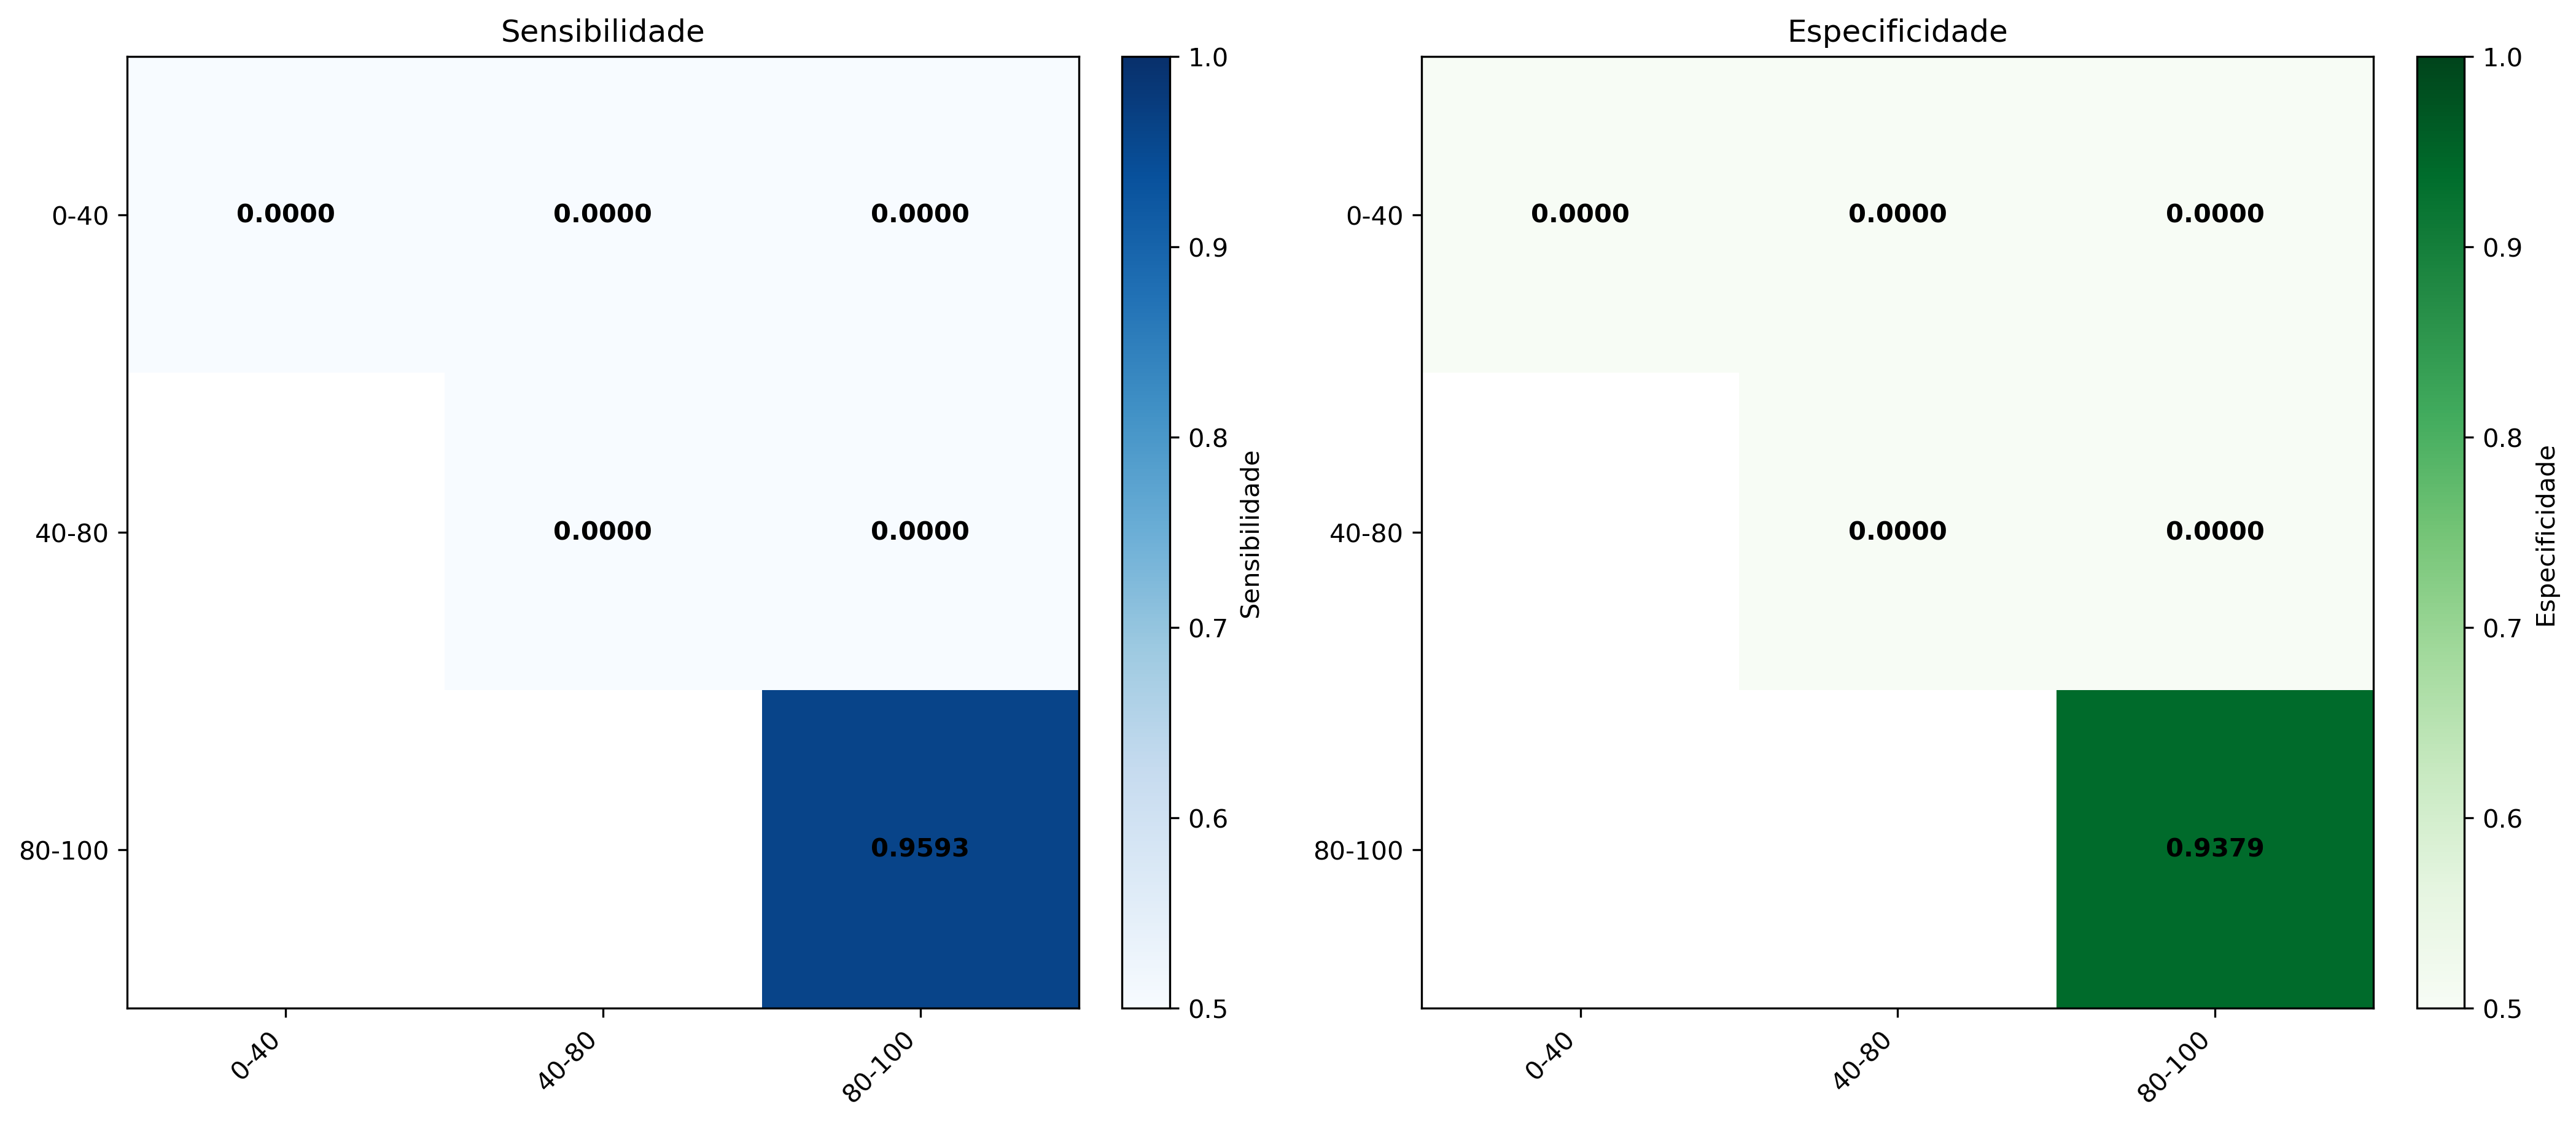

In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Filtra apenas o threshold 0.5
df_filtrado = df_todos_resultados[df_todos_resultados['Threshold'] == 0.5]

# Ordena faixas
faixas_x = sorted(df_filtrado['Faixa1'].unique(), key=lambda x: float(x.split('-')[0]))
faixas_y = sorted(df_filtrado['Faixa2'].unique(), key=lambda x: float(x.split('-')[0]))

# Cria matrizes para sensibilidade (recall) e especificidade
matriz_sens = np.full((len(faixas_y), len(faixas_x)), np.nan)
matriz_espec = np.full((len(faixas_y), len(faixas_x)), np.nan)

# Preenche as matrizes
for _, row in df_filtrado.iterrows():
    i = faixas_y.index(row['Faixa2'])
    j = faixas_x.index(row['Faixa1'])
    matriz_sens[i, j] = row['Recall']          # sensibilidade
    matriz_espec[i, j] = row["Especificidade"]    # especificidade

# Limites de cores
min_sens = df_filtrado['Recall'].min()
min_espec = df_filtrado["Especificidade"].min()

# Gráficos lado a lado (aumentando DPI)
fig, axs = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True, dpi=300)
titulos = ["Sensibilidade", "Especificidade"]
matrizes = [matriz_sens, matriz_espec]
cmaps = ['Blues', 'Greens']
mins = [min_sens, min_espec]

for i in range(2):
    im = axs[i].imshow(matrizes[i], cmap=cmaps[i], vmin=0.5, vmax=1)
    axs[i].set_xticks(range(len(faixas_x)))
    axs[i].set_xticklabels(faixas_x, rotation=45, ha='right')
    axs[i].set_yticks(range(len(faixas_y)))
    axs[i].set_yticklabels(faixas_y)
    axs[i].set_title(f"{titulos[i]}")

    # Valores dentro das células (duas casas decimais, negrito)
    for y in range(len(faixas_y)):
        for x in range(len(faixas_x)):
            val = matrizes[i][y, x]
            if not np.isnan(val):
                axs[i].text(
                    x, y, f"{val:.4f}",
                    ha='center', va='center',
                    color='black', fontsize=10, fontweight='bold'
                )

    # Barra de cor
    fig.colorbar(im, ax=axs[i], orientation='vertical', fraction=0.046, pad=0.04, label=titulos[i])

# Salva em PNG e PDF com alta resolução
#plt.savefig("heatmaps_sens_espec_.png", dpi=300, bbox_inches='tight')
#plt.savefig("heatmaps_sens_espec_.pdf", dpi=300, bbox_inches='tight')

plt.show()
